# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

Dataset here : https://www.batadal.net/data.html You will need Training Dataset 1, Training Dataset 1 and Test Dataset.

## Group Number : 15

## Student 1 
### Name : Nikhil Saldanha
### ID : 4998707

## Student 2
### Name : Sharwin Bobde
### ID : 5011639

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

### Instructions for setting up
- Create a folder for the data called `data/`.
- Download the data into `data/` from [here](https://www.batadal.net/data.html).
- Setup virtualenv: `virtualenv -p python3 env`
- Enter virtualenv: `source env/bin/activate`
- Start Jupyter Server: `jupyter notebook .`

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
from tqdm import tqdm

In [4]:
from sklearn.neighbors import LocalOutlierFactor

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
import datetime

In [8]:
from PCA import PCA_Component

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
from N_gram import N_gram_Component

In [11]:
from metrics import run_metrics

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [12]:
data_1 = pd.read_csv("data/BATADAL_dataset03.csv")
# account for space after the comma in the delimiter
data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")
test_data = pd.read_csv("data/BATADAL_test_dataset.csv")

# convert DATETIME column to datetime
data_1["DATETIME"] = pd.to_datetime(data_1.DATETIME)
data_2["DATETIME"] = pd.to_datetime(data_2.DATETIME)
test_data["DATETIME"] = pd.to_datetime(test_data.DATETIME)

<ipython-input-12-356782e260f6>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_2 = pd.read_csv("data/BATADAL_dataset04.csv", delimiter=r",\s{0,1}")


In [13]:
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

We manually add the attack flag column to the test data from provided information by BATADAL

In [29]:
test_data['ATT_FLAG'] = pd.Series(np.zeros(test_data.shape[0])) # default 0 (no-attack)

# start setting values
attack_times = [
    [pd.Timestamp("2017-01-16T09"), pd.Timestamp("2017-01-19T06")],
    [pd.Timestamp("2017-01-30T08"), pd.Timestamp("2017-02-02T00")],
    [pd.Timestamp("2017-02-09T03"), pd.Timestamp("2017-02-10T09")],
    [pd.Timestamp("2017-02-12T01"), pd.Timestamp("2017-02-13T07")],
    [pd.Timestamp("2017-02-24T05"), pd.Timestamp("2017-02-28T08")],
    [pd.Timestamp("2017-03-10T14"), pd.Timestamp("2017-03-13T21")],
    [pd.Timestamp("2017-03-25T20"), pd.Timestamp("2017-03-27T01")]
]

# showing how distribution of 0s and 1s changes
print(test_data['ATT_FLAG'].value_counts(normalize=True))
for times in attack_times:
    indexes = np.where(test_data['DATETIME'].between(times[0], times[1], inclusive=True))[0]
    test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)
    print(test_data['ATT_FLAG'].value_counts(normalize=True))

0.0    1.0
Name: ATT_FLAG, dtype: float64
0.0    0.966491
1.0    0.033509
Name: ATT_FLAG, dtype: float64
0.0    0.946865
1.0    0.053135
Name: ATT_FLAG, dtype: float64
0.0    0.946865
1.0    0.053135
Name: ATT_FLAG, dtype: float64
0.0    0.943035
1.0    0.056965
Name: ATT_FLAG, dtype: float64
0.0    0.895165
1.0    0.104835
Name: ATT_FLAG, dtype: float64
0.0    0.884634
1.0    0.115366
Name: ATT_FLAG, dtype: float64
0.0    0.870273
1.0    0.129727
Name: ATT_FLAG, dtype: float64


<ipython-input-29-240bdbd1a0ba>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)


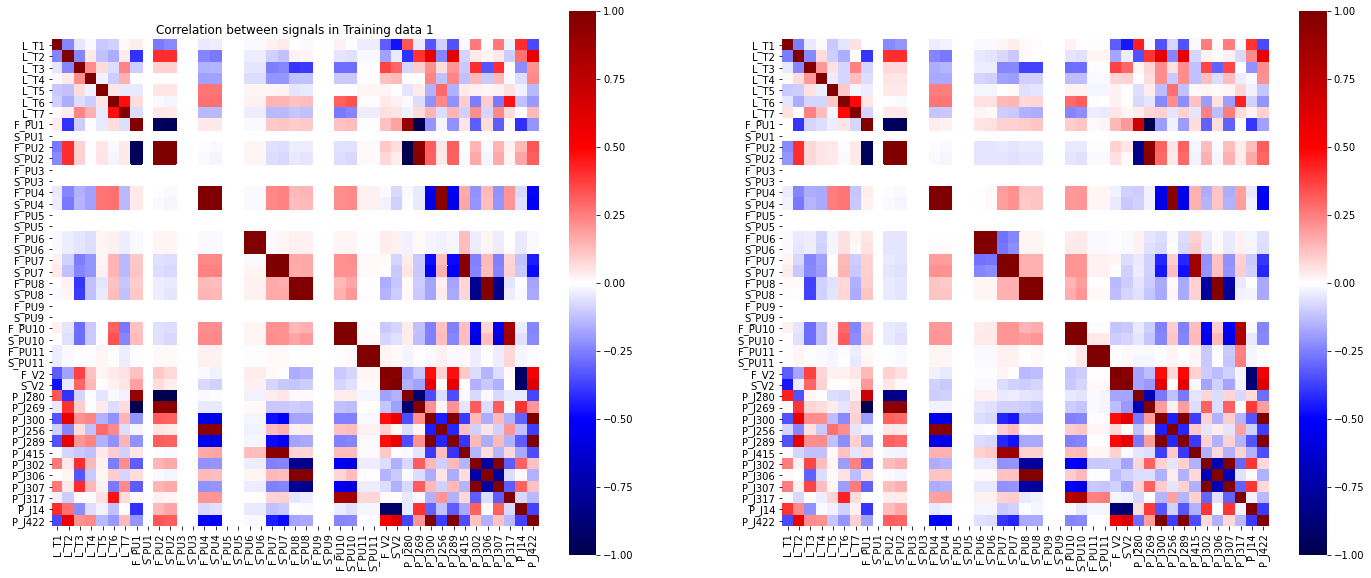

In [15]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(24, 10))

sns.heatmap(data_1[signals].corr(), square=True, vmin=-1, vmax=1, ax=ax1, cmap='seismic')
ax1.set_title("Correlation between signals in Training data 1")
sns.heatmap(data_2[signals].corr(), square=True, vmin=-1, vmax=1, ax=ax2, cmap='seismic')
ax1.set_title("Correlation between signals in Training data 1")
plt.show()

100%|██████████| 43/43 [00:00<00:00, 1268.52it/s]


Rendering... Please wait


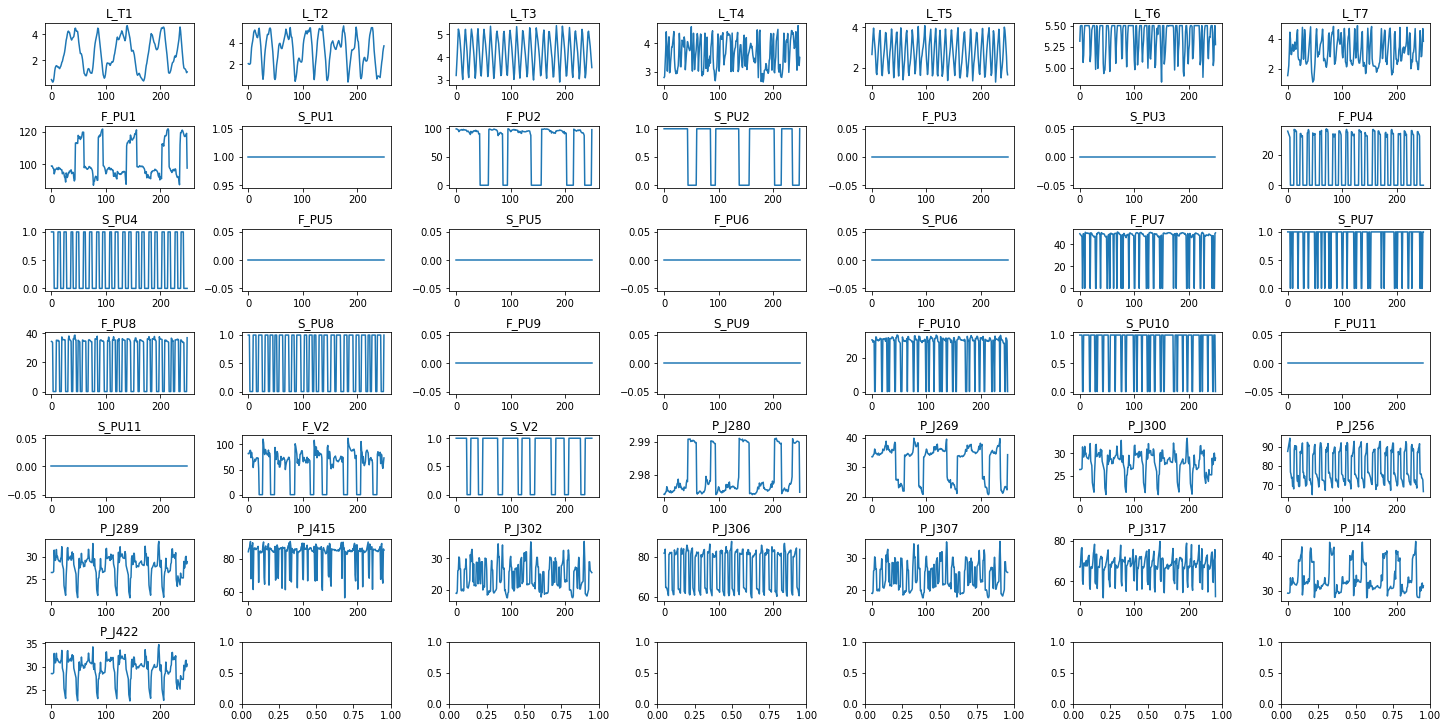

In [16]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
for i in tqdm(range(len(signals))):
       a,b = (int(i/7), i%7)
       axs[a,b].plot(range(250), data_1[signals[i]][0:250])
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

100%|██████████| 43/43 [00:00<00:00, 537.53it/s]


Rendering... Please wait


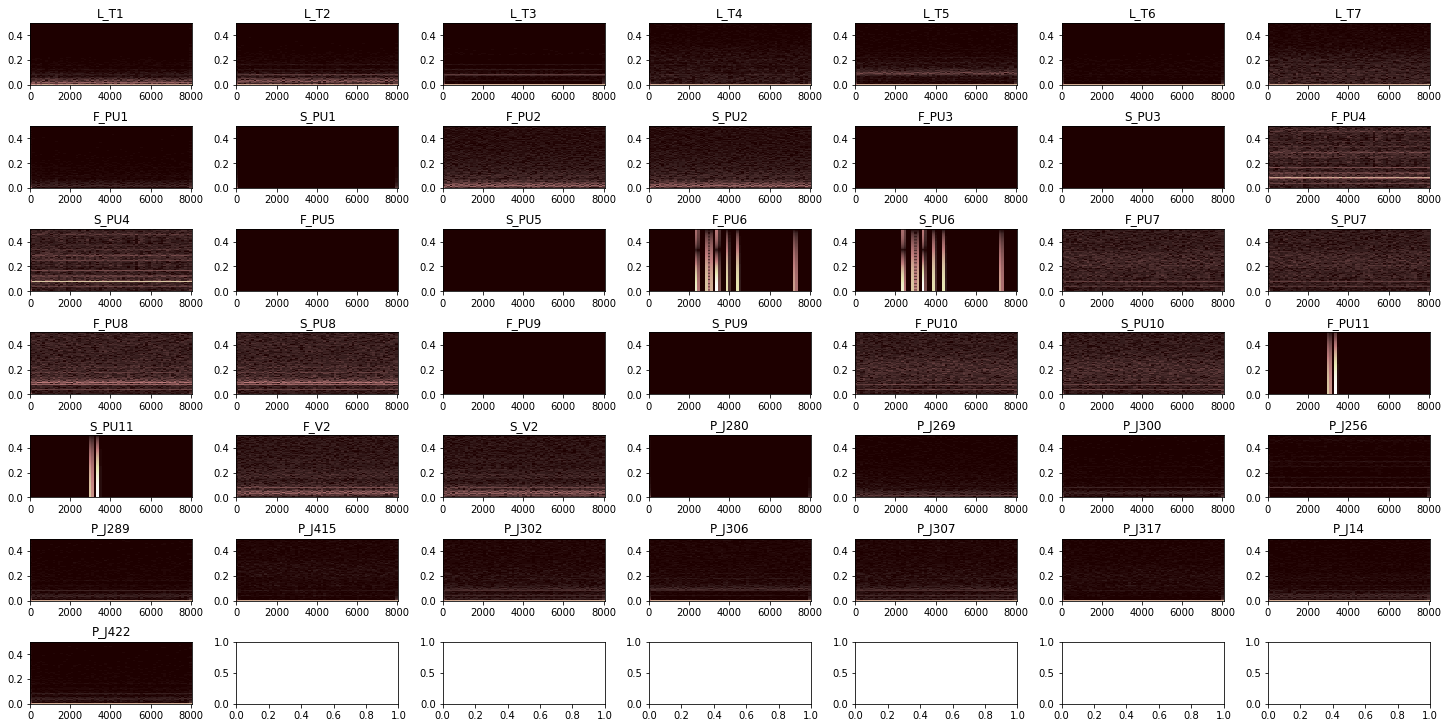

In [17]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
for i in tqdm(range(len(signals))):
       a,b = (int(i/7), i%7)
       f, t, Zxx = stft(data_1[signals[i]][0:8000], nperseg=256)
       axs[a,b].pcolormesh(t, f, np.abs(Zxx), cmap='pink')
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

In [18]:
def slide_dataset(data: np.array, window_size: int, stride: int = 1) -> np.array:
    """
    Takes Nx1 dimensional data in form of a numpy array and
    creates data by sampling in a window_size W and stride S.
    Returns a (N - W)/S x W dimensional data
    """
    N = data.shape[0]
    num_samples = int(N - window_size / stride)
    
    # new empty numpy array to store the data with sliding window
    slid_dataset = np.empty((num_samples, window_size))

    # loop over the data and sample according
    # to window size and stride
    for i in range(window_size, N, stride):
        slid_dataset[i-window_size] = data[i-window_size:i]
    
    return slid_dataset

In [19]:
def plot_prediction(y_true, y_pred, ax, title, num_points=1000):
    ax.plot([i for i in range(num_points)], y_true[:num_points], label="actual")
    ax.plot([i for i in range(num_points)], y_pred[:num_points], label="predicted")
    ax.legend()
    ax.set_title(title)

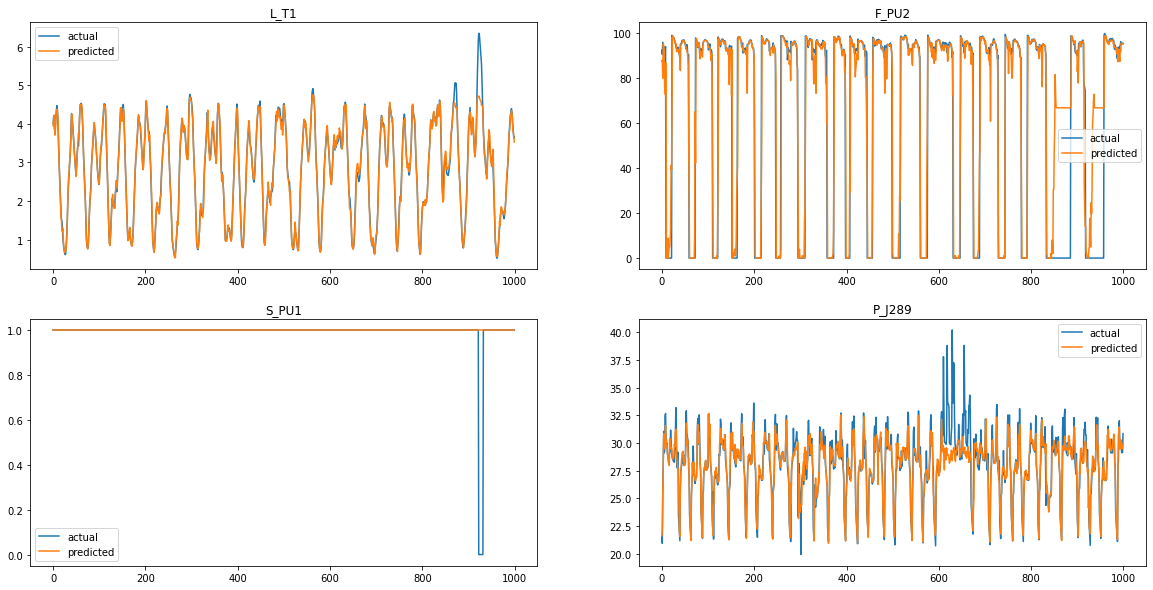

In [20]:
# decide window size
window_size = 24

# decide signals
signals = ["L_T1", "F_PU2", "S_PU1", "P_J289"]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches((20,10))
for i, signal in enumerate(signals):
    # create sliding window dataset
    slid_train = slide_dataset(data_1[signal].to_numpy(), window_size)
    slid_test = slide_dataset(test_data[signal].to_numpy(), window_size)

    # create train, test and validation sets
    X_train = slid_train[:,:window_size-1]
    y_train = slid_train[:,window_size-1]

    X_test = slid_test[:,:window_size-1]
    y_test = slid_test[:,window_size-1]
    
    # create a random forest regression model
    rf_clf = RandomForestRegressor()
    
    # fit and predict
    rf_clf.fit(X_train, y_train)
    
    y_pred_test = rf_clf.predict(X_test)
    plot_prediction(y_test, y_pred_test, axs[int(i/2), i%2], title=signal)
plt.show()

### 1b. Answers to the three questions

**1. What types of signals are there?**

In the dataset, the signals prefixed with "S" are state variables which are discrete, the signals prefixed with "L" denote the water levels, "F" signals are for flow and "P" signals are for inlet and outlet pressure. We see that each of these signals have their own characteristic shape.

**2. Are the signals correlated? Do they show cyclic behavior?**

From the heatmaps we can clearly see which signals are positively and negatively correlated in both the training datasets. The cyclic nature of the signals can be seen in the individual signal plots and the STFT (Short Term Fourier Transform) plots. while the individual signal plots are in time domain, the STFT is in frequency domain. Thus we can see the characteristic frequencies of the signals through time. A simple way of interpreting them is:

-  prominent horizontal lines: certain frequencies are more prominent therefore is cyclic in nature.
-  prominent vertical lines: signal changes abruptly in a short time.

Thus, we see that *many* signals are cyclic in nature.


**3. Is predicting the next value in a series easy or hard? Use any method from class**

We make an attempt at predicting the next value in the series of the signals L_T1, F_PU2, S_PU1, P_J289 using the sliding window technique. According to our observations, the model can reasonable predict the next value of the signal when there are no sudden and large changes in it. In our visualizations above, we can see that when S_PU1 drops to 0 and then back to 1 in a short interval, the model is not able to predict this. We can see similar patterns in other signals as well. Hence, we would say that whether it is hard or easy depends on the characteristic of the signal itself.

## 2. LOF task – 1/2 A4 – Nikhil Saldanha

### 2a. Plot LOF scores
will take upto 5mins. Please wait...

In [21]:
# remove label and datetime column
X_train = data_1[set(data_1.columns)-{"ATT_FLAG", "DATETIME"}].to_numpy()
y_train = np.zeros((X_train.shape[0], ))

X_valid = data_2[set(data_2.columns)-{"ATT_FLAG", "DATETIME"}].to_numpy()
y_valid = data_2["ATT_FLAG"].to_numpy()
# convert to 1s for attack and 0s for normal
y_valid = y_valid == 1

lofs = []
nns = [i for i in range(1, 120)]
tps = []
fns = []
for nn in tqdm(nns):
    clf = LocalOutlierFactor(n_neighbors=nn, algorithm='kd_tree', leaf_size=100,
                             metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
    clf.fit(X_train)
    lof = clf.negative_outlier_factor_
    lofs.append(lof)

    y_pred = clf.predict(X_valid)
    y_pred = y_pred == -1
    y_pred = y_pred.astype(float)

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    tps.append(tp)
    fns.append(fn)

100%|██████████| 119/119 [01:40<00:00,  1.19it/s]


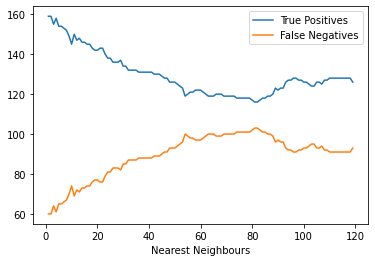

In [22]:
plot_df = pd.DataFrame({"True Positives": tps, "False Negatives": fns, "Nearest Neighbours": nns})
sns.lineplot(x="Nearest Neighbours", y=tps, data=plot_df, legend='brief', label="True Positives")
sns.lineplot(x="Nearest Neighbours", y=fns, data=plot_df, legend='brief', label="False Negatives")

We choose a nearest neighbour value of 95 since at that value, the number of TPs and FNs are stable and do not change with increase nearest neighbour values. At this value, we see the distribution of LOF scores below:

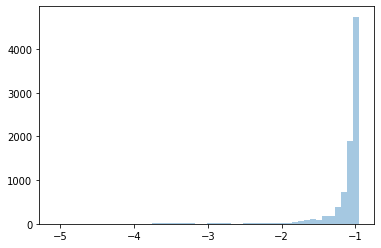

In [23]:
sns.distplot(lofs[94], kde=False)
plt.show()

### 2b. Analysis and answers to the questions

**1. Do you see large abnormalities in the training data? Can you explain why these occur?**
Yes, we can see the large abnormalities in the training data through the LOF scores above. The model takes -1.5 as the threshold below which the samples are classified as outliers. These are possibly the datapoints that have sudden changes in their values as we saw in the familiarization task.


**2. It is best to remove such abnormalities from the training data since you only want to model normal behavior?**
We would say that it is not a good idea to remove these from the training data since they are already part of normal behaviour and we should model these kinds of patterns as well.


**3. Describe the kind of anomalies you can detect using LOF**

With LOF you can detect point anomalies since it measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. A point anomaly is defined as: A single instance of data that is anomalous since it deviates largely from the rest of the data points.

## 3. PCA task – 1/2 A4 – Sharwin Bobde (5011639)

### 3a. Plot PCA residuals

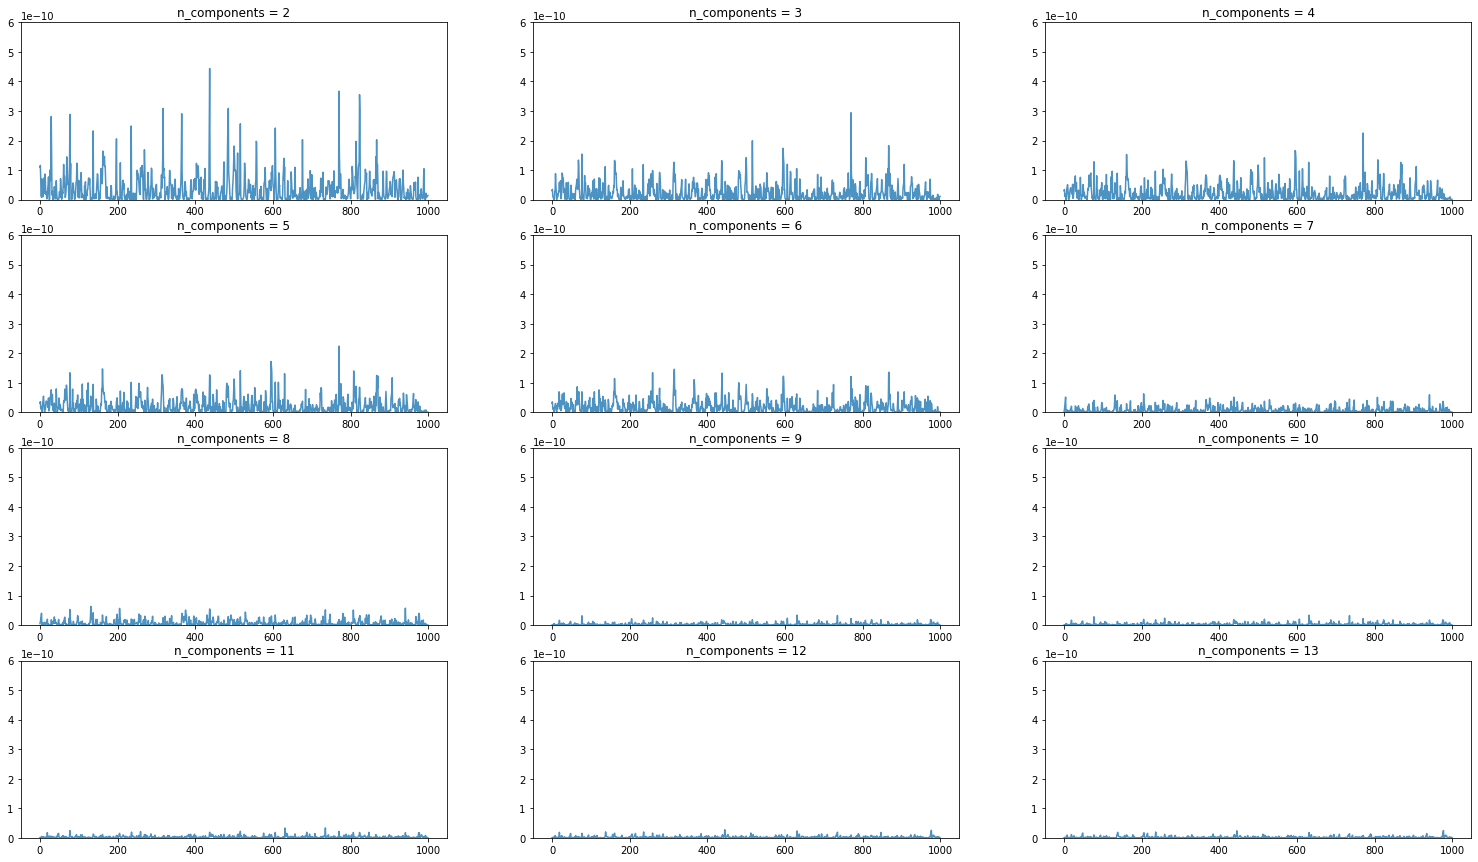

In [24]:
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
X = data_1[signals].to_numpy()

signal_to_PLOT = signals.index('P_J280') # selected P_J280 because shows importance
pca = PCA_Component()
pca.set_X(X)

f, axs = plt.subplots(4,3,figsize =(26, 15))
for i in range(12):
    n_components = i+2 # start with 2 components
    pca.PCA_fit_transform(n_components)
    R = pca.calculate_residual(X)
    s = R[:,signal_to_PLOT]

    axs[int(i/3), i%3].set_title("n_components = " + str(n_components))
    axs[int(i/3), i%3].plot(range(1000), s[0:1000], alpha = 0.8)
    axs[int(i/3), i%3].set_ylim((0,6e-10)) # consistent y-axis

### 3b. Analysis and answers to the questions

### Choosing `n_components`
We will use the mean and standard deviation of anomaly score (the probability of a row being an anomaly) to choose. The anomaly score should be low for normal data and high for data we know is outlier. Moreover, we can split `data 2` in two parts (inlier and outlier) to see that it firs the inliers as normal data.

100%|██████████| 41/41 [00:09<00:00,  4.37it/s]


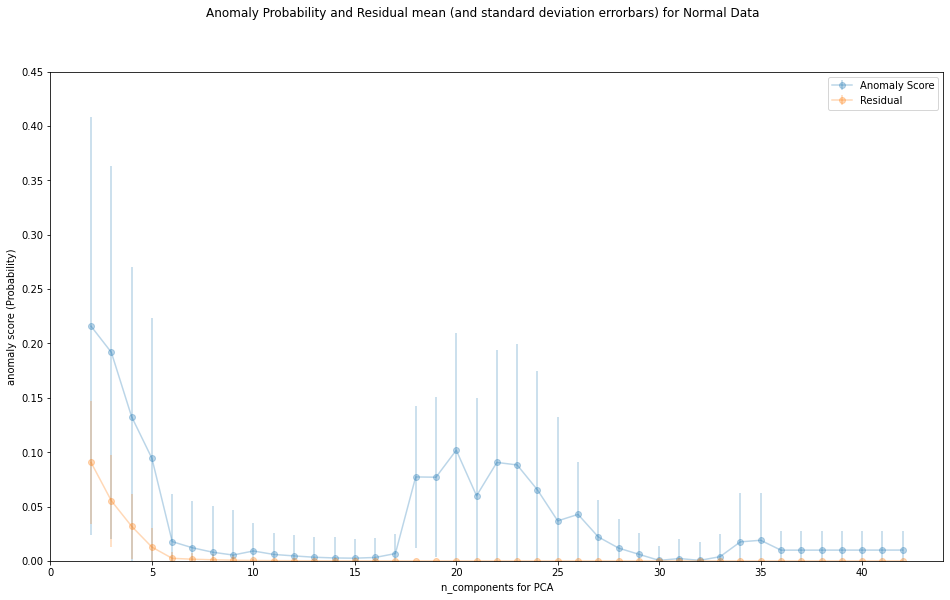

In [25]:
pca = PCA_Component()
pca.set_X(X)

per_n_components = []
per_n_components_R = []

for n_components in tqdm(range(2, 43)): # try all possible n_components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(X)
    per_n_components.append(score)

    R = pca.calculate_residual(X)
    R = np.sum(R, axis=1) # sum up residuals for all signals
    per_n_components_R.append(R)
    
mean_ = np.mean(per_n_components, axis=1)
std_ = np.std(per_n_components, axis=1)
mean_R = np.mean(per_n_components_R, axis=1)
std_R= np.std(per_n_components_R, axis=1)

fig = plt.figure(figsize=(16, 9))
fig.suptitle("Anomaly Probability and Residual mean (and standard deviation errorbars) for Normal Data")
plt.errorbar(x=range(2, 43), y=mean_, yerr=std_, fmt='o-', alpha = 0.3, label="Anomaly Score")
plt.errorbar(x=range(2, 43), y=mean_R, yerr=std_R, fmt='o-', alpha = 0.3, label="Residual")
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.ylim((0,0.45)) # consistent y-axis
plt.legend()
plt.show()

The above plot isjust to show the relation between residual and anomaly score. The mere reduction in residual score does not entail lower anomaly score.

100%|██████████| 41/41 [00:05<00:00,  6.88it/s]


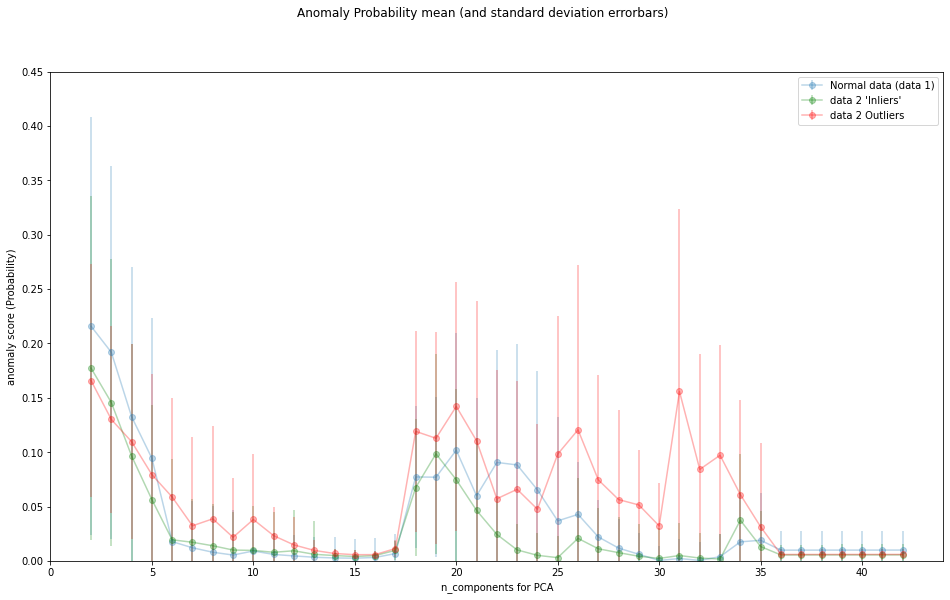

In [26]:
pca = PCA_Component()
pca.set_X(X) # fit for normal data
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]
Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]

per_n_components_outlier = []
per_n_components_inlier = []
for n_components in tqdm(range(2, 43)): # try all possible n_components
    pca.PCA_fit_transform(n_components)
    score = pca.anomaly_score(Z_outliers)
    per_n_components_outlier.append(score)
    score = pca.anomaly_score(Z_inliers)
    per_n_components_inlier.append(score)
    
mean_outlier = np.mean(per_n_components_outlier, axis=1)
std_outlier = np.std(per_n_components_outlier, axis=1)
mean_inlier = np.mean(per_n_components_inlier, axis=1)
std_inlier = np.std(per_n_components_inlier, axis=1)


fig = plt.figure(figsize=(16, 9))
fig.suptitle("Anomaly Probability mean (and standard deviation errorbars)")
plt.errorbar(x=range(2, 43), y=mean_, yerr=std_, fmt='o-', alpha=0.3, label="Normal data (data 1)")
plt.errorbar(x=range(2, 43), y=mean_inlier, yerr=std_inlier, fmt='o-', alpha=0.3, c='g', label="data 2 'Inliers'")
plt.errorbar(x=range(2, 43), y=mean_outlier, yerr=std_outlier, fmt='o-', alpha=0.3,c='r', label="data 2 Outliers")
plt.ylim((0,0.45)) # consistent y-axis
plt.ylabel('anomaly score (Probability)')
plt.xlabel('n_components for PCA')
plt.legend()
plt.show()

### Select `n_components = 10`
This is because it models the normal data (entire data_1 and data_2 inliers) well with very low residual error AND it shows high anomaly score for data we know is outlier while generalising using less number of components.

### Abnormalities in training data

**Q. Do you see large abnormalities in the trainingdata?**

In the above plot it is quite visible that outlier data has higher probability of being tagged anomalous. We see at `n_components = 31` this observation is most prominant.

**Q. Can you explain why these occur?**

This is because the outlier points (attacks) have abnormal behaviour and their inverse PCA mapping is very erroneous and thus have higher residual. This is because these points have high variance for principal components which usually shouldn't.

**Q. Describe the kind of anomalies you can detect using PCA.**

We can detect outlier points which have a different variance than the regular distribution in the direction of the principal components.

## 4. ARMA task – 1/2 A4 - Nikhil Saldanha

### 4a. Print relevant plots and/or metrics to determine the parameters.

We analyse these 4 signals: "L_T7", "F_PU10", "S_PU10", "S_PU11" for detecting attacks since they were important according to the analysis in the Taormina et.al. paper: **Characterizing Cyber-Physical Attacks on Water Distribution Systems**

We first visualize each of the signals

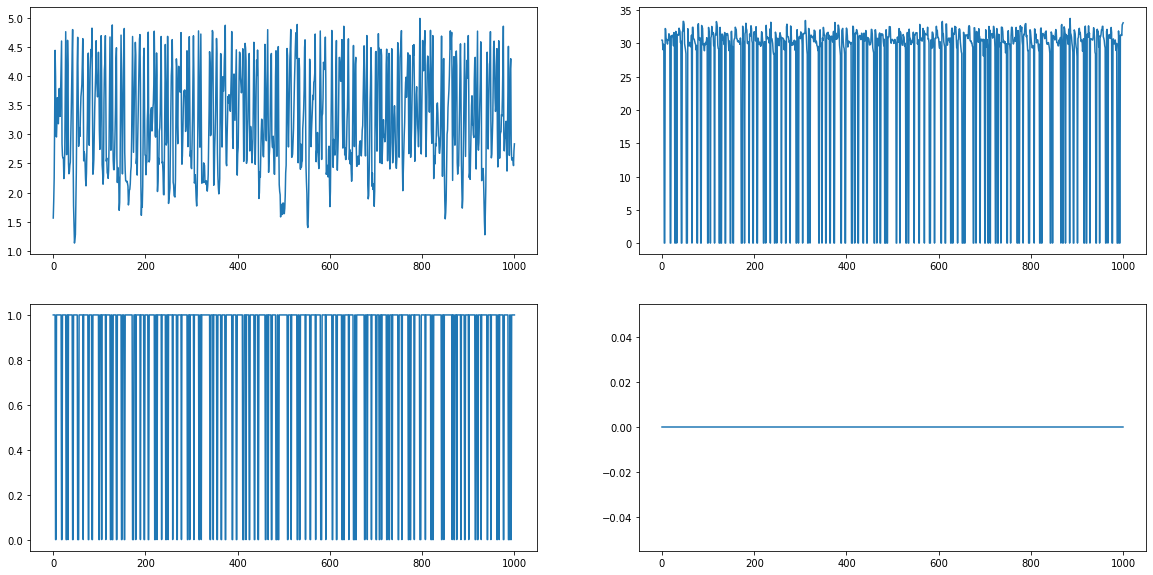

In [27]:
signals = ["L_T7", "F_PU10", "S_PU10", "S_PU11"]
fig, axs = plt.subplots(2, 2)
fig.set_size_inches((20,10))

data_1.loc[:1000, signals[0]].plot(ax=axs[0, 0])
data_1.loc[:1000, signals[1]].plot(ax=axs[0, 1])
data_1.loc[:1000, signals[2]].plot(ax=axs[1, 0])
data_1.loc[:1000, signals[3]].plot(ax=axs[1, 1])

**To determine the amount of differencing:** The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. We can see that these signals are all stationary since they do not have an obvious trend. We can even do a test called the Augmented Dickey-Fuller test that can inform us about the degree to which this data is stationary.

The ADF test is a statistical test with the following hypotheses

**Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
**Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

### NOTE: since ARMA modelling takes quite a while, we continue forward with only 1 signal L_T7 since it the most important (representing water level)

### Please wait for upto 30 mins

In [28]:
adf = adfuller(data_1["L_T7"])
print("S_PU10")
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

S_PU10
ADF Statistic: -17.489711
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can see that our statistic values of -17 is less than its corresponding critical values at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

From the above tests we can conclude that the chosen signal is stationary and we do not need differencing.

**To determine the parameter for the number of AR Terms:** We plot the partial auto-correlation function and see where there is a sharp cutoff with respect to the number of lag terms. According to the figure below, we should use around 2

In [29]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

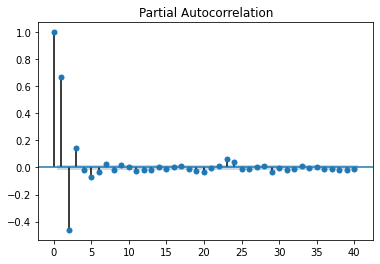

In [30]:
plot_pacf(data_1["L_T7"])
plt.show()

**To determine the parameter for the number of MA terms:** We do this similarly to the above technique, except we look at the Autocorrelation Plot. We get around 3.

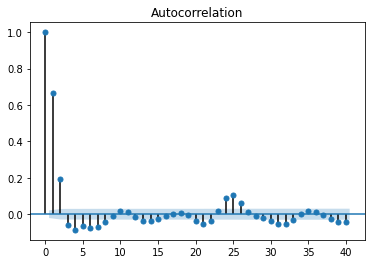

In [31]:
plot_acf(data_1["L_T7"])
plt.show()

### 4b. Plots to study the detected anomalies

We first do a test run on the train data and see the resuduals

                              ARMA Model Results                              
Dep. Variable:                   L_T7   No. Observations:                 8761
Model:                     ARMA(2, 3)   Log Likelihood               -7034.026
Method:                       css-mle   S.D. of innovations              0.540
Date:                Tue, 26 May 2020   AIC                          14082.052
Time:                        22:42:24   BIC                          14131.599
Sample:                             0   HQIC                         14098.934
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3025      0.013    262.963      0.000       3.278       3.327
ar.L1.L_T7     0.9479      0.111      8.515      0.000       0.730       1.166
ar.L2.L_T7    -0.2676      0.020    -13.059      0.0

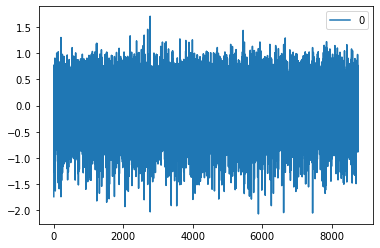

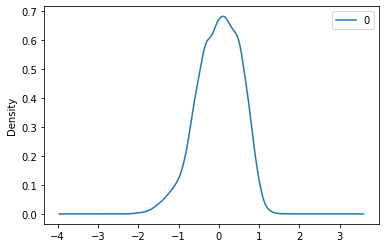

                 0
count  8761.000000
mean     -0.000022
std       0.540251
min      -2.069276
25%      -0.362245
50%       0.031854
75%       0.409381
max       1.704490


In [32]:
model = ARIMA(data_1["L_T7"], order=(2,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

We train on the full training data 1 and test on the first 500 samples of the test set 

**This is where you have to wait for 30 mins. We are sad too :(**

In [33]:
train, test = data_1["L_T7"].to_numpy(), test_data["L_T7"].to_numpy()[:500]
test_y_arma = test_data["ATT_FLAG"].to_numpy()[:500]
history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test))):
#     print(t)
    model = ARIMA(history, order=(2, 0, 3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

100%|██████████| 500/500 [16:48<00:00,  2.02s/it]

Test MSE: 0.281


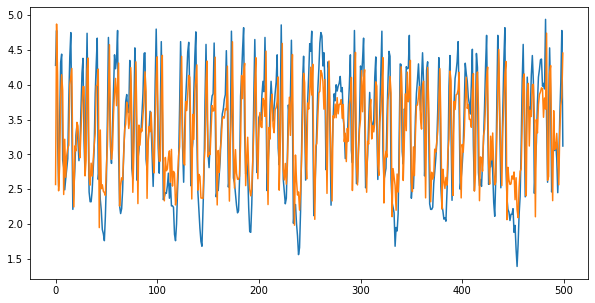

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(test)
plt.plot(predictions)
plt.show()

To classify a point as an anomaly, we maintain a standard deviation of errors in 24 hour windows, between ground truth and predicted. If the deviation is more than 3 standard deviations of usualy error away from the ground truth value, then we classify that as an anomaly

In [35]:
def detect_classify_anomalies(df,window):
    """
    """
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    return df

predicted_df=pd.DataFrame()
predicted_df['actuals']=test
predicted_df['predicted']=np.array(predictions).flatten()
predicted_df.reset_index(inplace=True)
del predicted_df['index']

# classify the predictions as anomaly or not in 24 hour windows
classify_df=detect_classify_anomalies(predicted_df,24)
# create a list of predictions
y_pred_arma = (~classify_df["anomaly_points"].isnull()).to_numpy().astype(int)

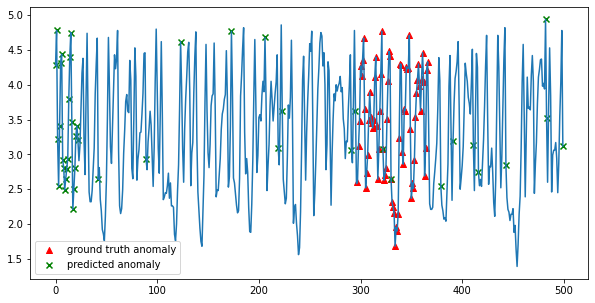

In [37]:
import pickle
plt.figure(figsize=(10, 5))
plt.plot(test)
plt.scatter(x=test_data.iloc[np.argwhere(test_y_arma==1).flatten()].index.to_numpy(),
            y=test_data.iloc[np.argwhere(test_y_arma==1).flatten()].L_T7.to_numpy(), marker="^", color="r", label="ground truth anomaly")
plt.scatter(x=test_data.iloc[np.argwhere(y_pred_arma==1).flatten()].index.to_numpy(),
            y=test_data.iloc[np.argwhere(y_pred_arma==1).flatten()].L_T7.to_numpy(), marker="x", color="g", label="predicted anomaly")
plt.legend()
plt.show()

# pickle ARMA in case something fails later
pickle.dump( test_y_arma, open( "test_y_arma.p", "wb" ) )
pickle.dump( y_pred_arma, open( "y_pred_arma.p", "wb" ) )

We can see that the model is not that great as it can classify only a few anomalies correctly and while getting too many false positives and also false negatives

### 4c. Analysis and answers to the questions

**1.  What kind of anomalies can you detect using ARMA models?**

The ARMA models can detect contextual anomalies. This is because ARMA models regress on previous values and make next step predictions based on them. A high residual means that the data point in question is anamolous in context to the previous values. The model represents the normal behaviour of the system given those same previous data points and can detect when the current value deviates from this.

**2. Which sensors can be modeled effectively using ARMA?**

Based on experiments, the sensors that correspond to water level and pressure were much easier to model since they showed cyclic behaviour. Flow and status signals are much harder to model since they do not have much of a cycle and jump too quickly from one level to another.

## 5. N-gram task – 1/2 A4 - Sharwin Bobde (5011639)

### 5a. Visualise discretization

In [38]:
# Selecting a subset of signals
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4',
       'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
       # make test data
test_data['ATT_FLAG'] = pd.Series(np.zeros(test_data.shape[0])) # default 0 (no-attack)

# start setting values
attack_times = [
    [pd.Timestamp("2017-01-16T09"), pd.Timestamp("2017-01-19T06")],
    [pd.Timestamp("2017-01-30T08"), pd.Timestamp("2017-02-02T00")],
    [pd.Timestamp("2017-02-09T03"), pd.Timestamp("2017-02-10T09")],
    [pd.Timestamp("2017-02-12T01"), pd.Timestamp("2017-02-13T07")],
    [pd.Timestamp("2017-02-24T05"), pd.Timestamp("2017-02-28T08")],
    [pd.Timestamp("2017-03-10T14"), pd.Timestamp("2017-03-13T21")],
    [pd.Timestamp("2017-03-25T20"), pd.Timestamp("2017-03-27T01")]
]

for times in attack_times:
    indexes = np.where(test_data['DATETIME'].between(times[0], times[1], inclusive=True))[0]
    test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)

X = data_1[signals].to_numpy()

<ipython-input-38-02be1188bbb9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ATT_FLAG'][indexes] = 1 # set 1 (attack)


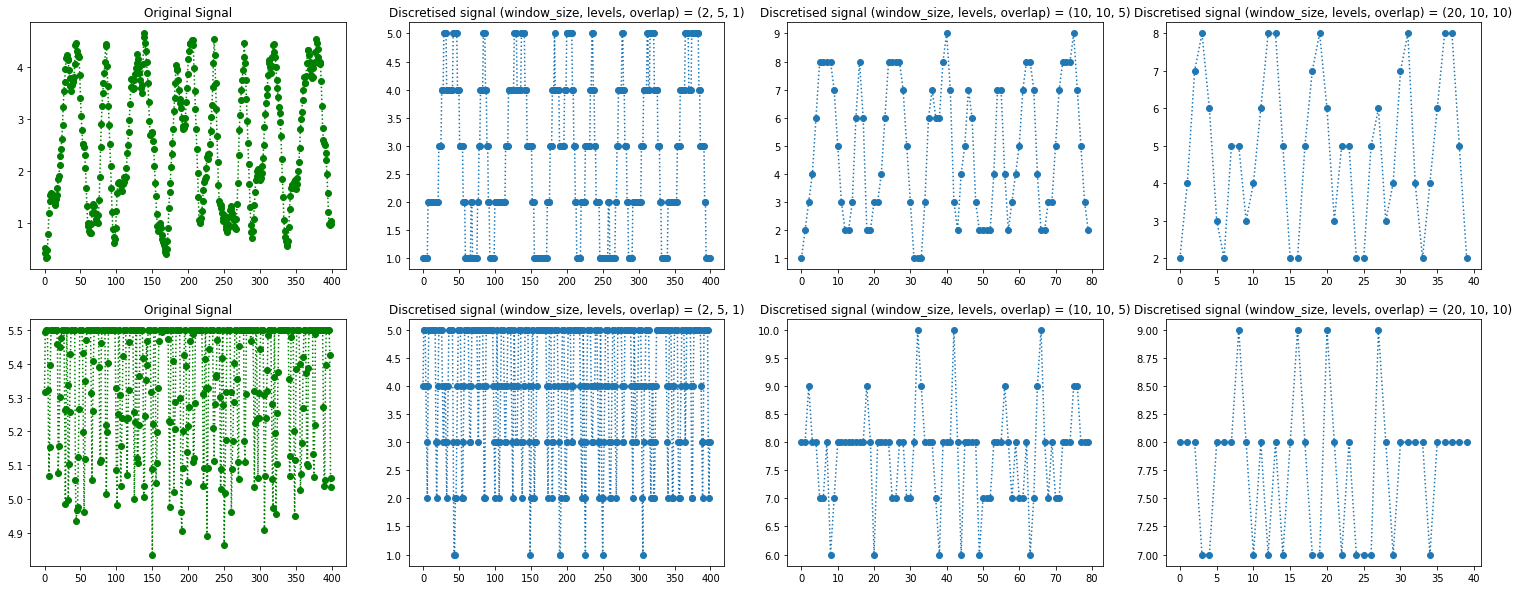

In [39]:
N_gram = N_gram_Component(2, len(signals))

# Plot
# different window_size and overlap
params = np.array([[2, 5, 1], [10, 10, 5], [20, 10, 10]])
fig, axs = plt.subplots(2,4)
fig.set_size_inches((26,10))
x_range = 400
axs[0,0].set_title('Original Signal')
axs[0,0].plot(range(x_range), X[0:x_range, 0], 'o:g')
axs[1,0].set_title('Original Signal')
axs[1,0].plot(range(x_range), X[0:x_range, 5], 'o:g')

for i in range(np.shape(params)[0]):
    X_windowed = N_gram.discretise(X, window_size=params[i,0], levels =params[i,1],  overlap=params[i,2])
    x_range_ = x_range / (params[i,0] - params[i,2])
    axs[0,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[0,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 0], 'o:')
    axs[1,i+1].set_title('Discretised signal (window_size, levels, overlap) = (' + str(params[i,0])+', '+str(params[i,1])+', '+str(params[i,2])+")")
    axs[1,i+1].plot(range(int(x_range_)), X_windowed[0:int(x_range_), 5], 'o:')

plt.show()

Lets select discretization parameters (window_size, levels, overlap) as (2, 5, 1)

### 5b. Analysis and answers to the questions. Also provide relevant plots.

### Selct $L$ and $N$ now

In [40]:
# Z is dataset_2
Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -999))[0]

Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]
Z_outlier_labels = Z_labels[Z_outlier_indexes]
Z_inlier_labels = np.zeros(len(Z_inlier_indexes))

# discretization is done only once 
params = (2,5,1)
Z_inlier_windowed = N_gram.discretise(Z_inliers, window_size=params[0], levels=params[1],  overlap=params[2])
Z_outlier_windowed = N_gram.discretise(Z_outliers, window_size=params[0], levels=params[1],  overlap=params[2])

Z_inlier_labels = N_gram.discretise_labels(Z_inlier_labels, window_size=params[0], overlap=params[2])
Z_outlier_labels = N_gram.discretise_labels(Z_outlier_labels, window_size=params[0], overlap=params[2])

# prepare test data
test_X = test_data[signals].to_numpy()
test_X_windowed = N_gram.discretise(test_X, window_size=params[0], levels=params[1],  overlap=params[2])
test_Y = test_data['ATT_FLAG'].to_numpy()
test_Y_windowed = N_gram.discretise_labels(test_Y, window_size=params[0], overlap=params[2])
print(test_X.shape)
print(test_Y.shape)

(2089, 36)
(2089,)


In [41]:
acc = []
auc = []
L_arr = [10, 20, 30] # above 20 it we highly undersample anomaly class
for L in L_arr:
    acc_ = []
    auc_ = []
    for N in range(1,5): # only upto 4 due to high processing time
        N_gram = N_gram_Component(N, len(signals))
        Z_in_profiles = N_gram.generate_profiles(Z_inlier_windowed, L)
        Z_in_profile_labels = N_gram.generate_profile_labels(Z_inlier_labels, L)

        Z_out_profiles = N_gram.generate_profiles(Z_outlier_windowed, L)
        Z_out_profile_labels = N_gram.generate_profile_labels(Z_outlier_labels, L)

        # Stack train data together for training k-NearestNeighbour
        train_X = np.vstack((Z_in_profiles, Z_out_profiles))
        train_Y = np.vstack((Z_in_profile_labels, Z_out_profile_labels))


        test_X_profiles = N_gram.generate_profiles(test_X_windowed, L)
        test_X_profile_labels = N_gram.generate_profile_labels(test_Y_windowed, L)

        N_gram.fit_kNN(train_X, train_Y)
        y_pred = N_gram.classify(test_X_profiles, L)

        result = run_metrics(test_X_profile_labels, y_pred)
        acc_.append(result['accuracy']) 
        auc_.append(result['auc']) 
        print(str([L,N]) + " done")
    acc.append(acc_)
    auc.append(auc_)
print("Completed :)")

/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[10, 1] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[10, 2] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[10, 3] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[10, 4] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[20, 1] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[20, 2] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[20, 3] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[20, 4] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[30, 1] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[30, 2] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[30, 3] done


/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)


[30, 4] done
Completed :)


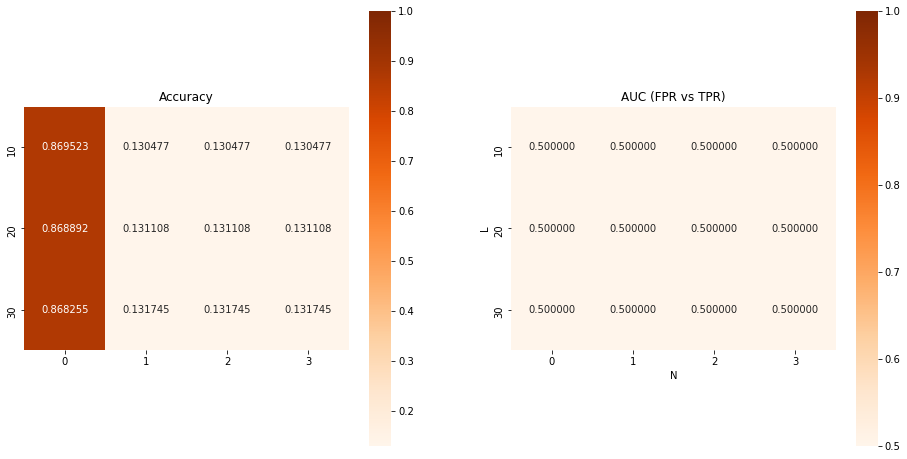

In [42]:
import seaborn as sns
fig, axs = plt.subplots(1, 2,figsize=(16,8))
axs[0].set_title("Accuracy")
sns.heatmap(acc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), ax=axs[0], yticklabels=L_arr)
axs[1].set_title("AUC (FPR vs TPR)")
sns.heatmap(auc, square=True, annot=True, fmt=".6f", cmap='Oranges', vmax=1, xticklabels=range(0,4), ax=axs[1], yticklabels=L_arr)
plt.xlabel('N')
plt.ylabel('L')
plt.show()

### Explaination
After discretization I tried combinations of L and N. For every block L I calculated N-Gram grequencies and made a profile signature. I found matching labels for this too. I used dataset 2 to charactersise normal and anomalous signatures. Using dataset1 causes heavy oversampling of the normal class.

Clearly there are a lot of things to optimise:
window_size, discretization levels, overlap, L, N, k in k-NN, minory class sampling... thus it proved to be quite difficult to optimise. Looking at the AUC the k-NN is clearly biased and always classifies as either always all 1s or all 0s

## 6.Comparision task 1 A4

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

In [17]:
# make train X and test X Y
X_train = data_1[signals].to_numpy()
X_test = test_data[signals].to_numpy()
Y_test = test_data['ATT_FLAG'].to_numpy()

results = {}

### The 4 Methods
We will train and test the 4 methods one by one, save the results in `results{}` and show all the results together.
#### LOF

In [18]:
from sklearn.neighbors import LocalOutlierFactor
from metrics import run_metrics

signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

X = data_1[signals].to_numpy()
test_X = test_data[signals].to_numpy()
test_Y = test_data['ATT_FLAG'].to_numpy()

clf = LocalOutlierFactor(n_neighbors=50, algorithm='kd_tree', leaf_size=100,
                         metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
clf.fit(X)
y_pred = clf.predict(test_X)
y_pred = y_pred == -1
y_pred = y_pred.astype(float)

result = run_metrics(test_Y, y_pred)
results['LOF'] = result

#### PCA

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PCA import PCA_Component
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4',
       'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

X = data_1[signals].to_numpy()
test_X = test_data[signals].to_numpy()
test_Y = test_data['ATT_FLAG'].to_numpy()

In [20]:
from PCA import PCA_Component
from metrics import run_metrics

pca = PCA_Component()
pca.set_X(X)
n_components = 10
pca.PCA_fit_transform(n_components)
y_pred = pca.classify(test_X)
result = run_metrics(test_Y, y_pred)
results['PCA'] = result

#### ARMA
We will use previously computed `test_y_arma` and `y_pred_arma` because we dont want to anger the reviewers :)

In [22]:
from metrics import run_metrics
import pickle
test_y_arma = pickle.load( open( "test_y_arma.p", "rb" ) )
y_pred_arma = pickle.load( open( "y_pred_arma.p", "rb" ) )

result = run_metrics(test_y_arma, y_pred_arma)
results['ARMA'] = result 

#### N-gram

In [38]:
from N_gram import N_gram_Component
from metrics import run_metrics
# Make train and test data
# Z is dataset_2
data_2['ATT_FLAG'] = data_2["ATT_FLAG"].replace(-999, 0)    # replace -999 with 0 for convenience
signals = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
       'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4',
       'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8',
       'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2',
       'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
       'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

Z = data_2[signals].to_numpy()
Z_labels = data_2['ATT_FLAG'].to_numpy()
Z_outlier_indexes = list(np.where(Z_labels == 1))[0]
Z_inlier_indexes = list(np.where(Z_labels == -0))[0]
print(Z_inlier_indexes)

Z_outliers = Z[Z_outlier_indexes, :]
Z_inliers = Z[Z_inlier_indexes, :]
Z_outlier_labels = Z_labels[Z_outlier_indexes]
Z_inlier_labels = Z_labels[Z_inlier_indexes]

L = 20
N = 1
N_gram = N_gram_Component(N, len(signals))

# discretization is done only once 
params = (2,5,1)
Z_inlier_windowed = N_gram.discretise(Z_inliers, window_size=params[0], levels=params[1],  overlap=params[2])
Z_outlier_windowed = N_gram.discretise(Z_outliers, window_size=params[0], levels=params[1],  overlap=params[2])

Z_inlier_labels = N_gram.discretise_labels(Z_inlier_labels, window_size=params[0], overlap=params[2])
Z_outlier_labels = N_gram.discretise_labels(Z_outlier_labels, window_size=params[0], overlap=params[2])

test_X = test_data[signals].to_numpy()
test_X_windowed = N_gram.discretise(test_X, window_size=params[0], levels=params[1],  overlap=params[2])
test_Y = test_data['ATT_FLAG'].to_numpy()
test_Y_windowed = N_gram.discretise_labels(test_Y, window_size=params[0], overlap=params[2])

[   0    1    2 ... 4174 4175 4176]


In [39]:
Z_in_profiles = N_gram.generate_profiles(Z_inlier_windowed, L)
Z_in_profile_labels = N_gram.generate_profile_labels(Z_inlier_labels, L)

Z_out_profiles = N_gram.generate_profiles(Z_outlier_windowed, L)
Z_out_profile_labels = N_gram.generate_profile_labels(Z_outlier_labels, L)

# Stack train data together for training k-NearestNeighbour
train_X = np.vstack((Z_in_profiles, Z_out_profiles))
train_Y = np.vstack((Z_in_profile_labels, Z_out_profile_labels))

test_X_profiles = N_gram.generate_profiles(test_X_windowed, L)
test_X_profile_labels = N_gram.generate_profile_labels(test_Y_windowed, L)

N_gram.fit_kNN(train_X, train_Y)
y_pred = N_gram.classify(test_X_profiles, L)

result = run_metrics(test_X_profile_labels, y_pred)
results["N-gram"] = result

/run/media/sharwinbobde/90604C06604BF190/Users/bshar/Desktop/Studies/Q4/CyberDA/cyber-data-analytics/Part-2/N_gram.py:142: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.knn.fit(X,Y)
/home/sharwinbobde/envs/CyberDA/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Results

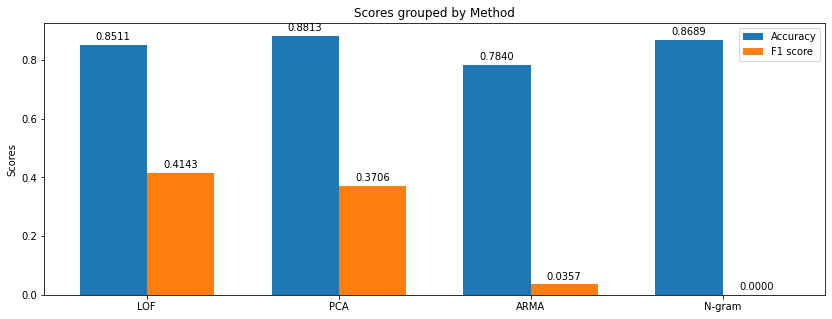

In [43]:
labels = []
acc = []
f1 = []

i=0
for key in ['LOF', 'PCA', 'ARMA', 'N-gram']:
    labels.append(key)
    acc.append(results[key]['accuracy'])
    f1.append(results[key]['f1'])
    i += 1
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches((14,5))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1, width, label='F1 score')
ax.set_ylabel('Scores')
ax.set_title('Scores grouped by Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str('%.4f'%height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

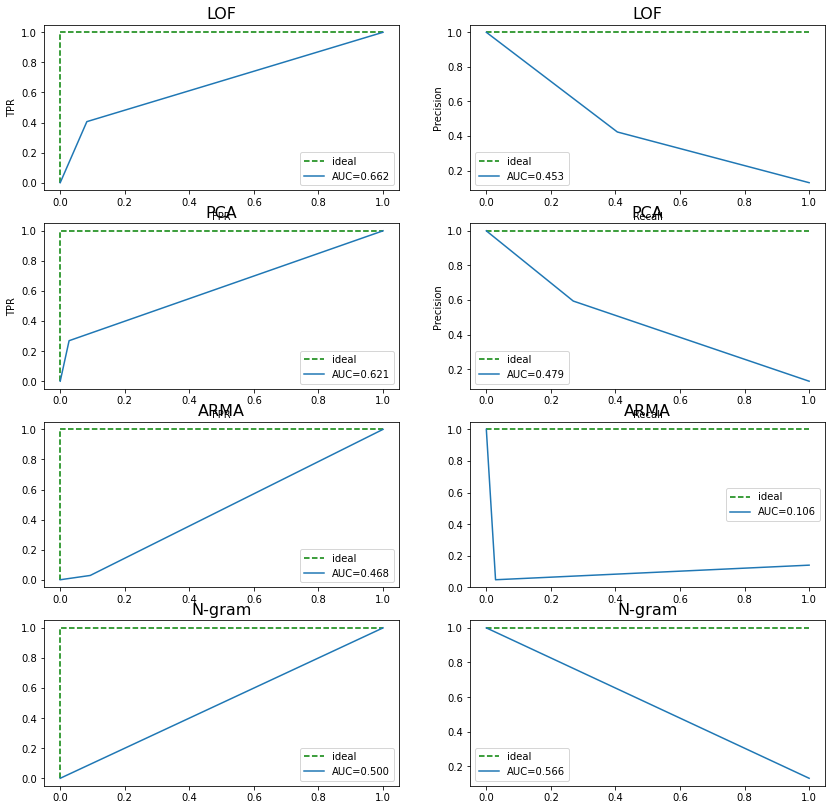

In [44]:
fig, axs = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(14,14)

for i in range(2):
    axs[i,0].set_xlabel("FPR")
    axs[i,0].set_ylabel("TPR")

    axs[i,1].set_xlabel("Recall")
    axs[i,1].set_ylabel("Precision")
i=0
for key in ['LOF', 'PCA', 'ARMA', 'N-gram']:
    result = results[key]
    axs[i,0].set_title(key, fontsize=16)
    axs[i,1].set_title(key, fontsize=16)

    axs[i,0].plot([0,0,1], [0,1,1], '--g', label="ideal")
    axs[i,0].plot(result['false_pos_rate'], result['true_pos_rate'], label="AUC=" + str("%.3f" % result["auc"]))
    axs[i,0].legend()

    axs[i,1].plot([0,1], [1,1], '--g', label="ideal")
    axs[i,1].plot(result['recall_curve'], result['precision_curve'], label="AUC=" + str("%.3f" % result["auc_pr"]))
    axs[i,1].legend()
    i += 1
plt.show()

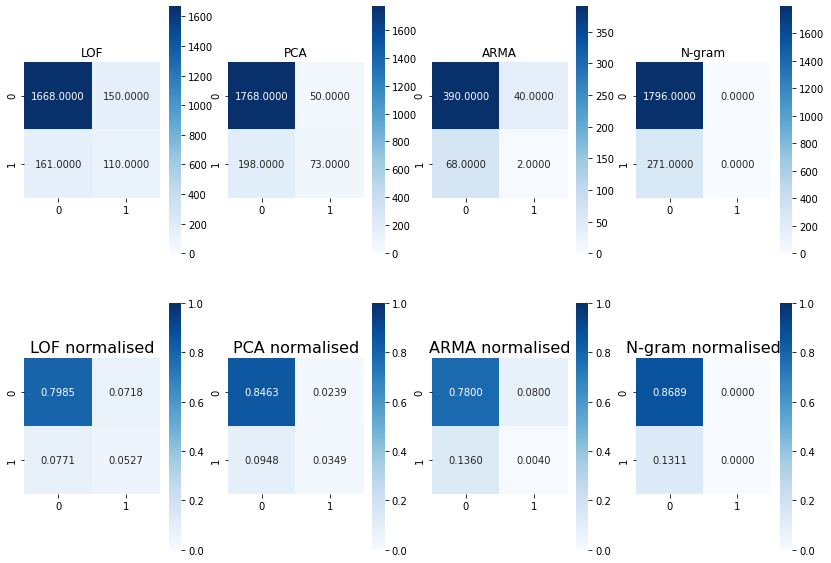

In [47]:
import seaborn as sns
fig, axs = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(14,10)

i=0
for key in ['LOF', 'PCA', 'ARMA', 'N-gram']:
    result = results[key]
    axs[0,i].set_title(key, fontsize=12)
    sns.heatmap(result['confusion'], ax=axs[0,i], square=True, annot=True, fmt=".4f",cmap='Blues', vmin=0)
    axs[1,i].set_title(key + " normalised", fontsize=16)
    sns.heatmap(result['confusion_norm'], ax=axs[1,i], square=True, annot=True, fmt=".4f",cmap='Blues', vmin=0, vmax=1)
    i += 1
plt.show()

### Explaination
We think that the confusion matrix is the best way to evaluate the different models since it allows us to see positives broken down into true positives and false positives. None of the methods we implement show great results but, LOF seems the best achieving normalised TP of 0.05 while keeping the FP to 0.07. The confusion matrix also allows us to see the False Negatives at the same time. FNs are important to keep low since it means that there is a breach in the system that we could not recognise which is more dangerous than having FPs.

According to our results, LOF seems the best strategy but we could definitely achieve better results if we could combine these methods to detect many different kinds of anomalies. PCA strongly came in second, because of its ability to generalise and reconstruct the signal well.

N-Gram and ARMA definitely performed the worst. ARMA was unable to model the signal well. It may require some more tuning to give good performance. Regarding N-gram, even though it is able to generate signatures of the data properly the classification mechanism with nearest neighbour method is giving high bias and it always outputs either of 0 or 1. It will require extensive hyperparameter optimisation to work properly or better study of the original signal.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.